In [3]:
import pandas as pd
import numpy as np
from scipy import optimize
import scipy as sc
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt #for plots
%matplotlib inline
from sklearn.metrics import accuracy_score, log_loss, roc_curve, roc_auc_score 
import statsmodels.api as sm

In [4]:

import matplotlib.pyplot as plt
import seaborn as sns

import time

from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV, train_test_split, StratifiedKFold, cross_validate, StratifiedShuffleSplit
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
from sklearn.svm import SVC

from collections import Counter
#from imblearn.over_sampling import SMOTE # doctest: +NORMALIZE_WHITESPACE

#from xgboost import XGBClassifier
from scipy import stats
import joblib

In [1]:
from scipy.io import arff
import seaborn as sns

In [2]:

arff_file = arff.loadarff('seismic-bumps.arff')


In [7]:
df = pd.DataFrame(arff_file[0])


In [8]:

### Categorizing columns in types of features and labels


label = 'class'
col_list_categorical = ['seismic', 'seismoacoustic', 'shift', 'ghazard']
col_list_numerical = ['genergy', 'gpuls', 'gdenergy', 'gdpuls', 'energy', 'maxenergy']
col_list_discrete = ['nbumps', 'nbumps2', 'nbumps3', 'nbumps4', 'nbumps5', 'nbumps6', 'nbumps7', 'nbumps89']
len([label]) + len(col_list_categorical) + len(col_list_discrete) + len(col_list_numerical)


19

In [9]:

for col in df.columns:
    if col in col_list_categorical + [label]:
        df[col] = df[col].str.decode("utf-8")
        if col == label:
            print(df[col].value_counts())
            df[col] = df[col].astype(int)

df.dtypes

0    2414
1     170
Name: class, dtype: int64


seismic            object
seismoacoustic     object
shift              object
genergy           float64
gpuls             float64
gdenergy          float64
gdpuls            float64
ghazard            object
nbumps            float64
nbumps2           float64
nbumps3           float64
nbumps4           float64
nbumps5           float64
nbumps6           float64
nbumps7           float64
nbumps89          float64
energy            float64
maxenergy         float64
class               int32
dtype: object

Text(0, 0.5, 'COUNT')

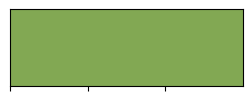

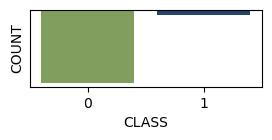

In [10]:

"""### Target Distributions Check"""

df['class'].value_counts() * 100 /len(df['class'])

colors = sns.color_palette([sns.color_palette("gist_earth_r")[2], sns.color_palette("gist_earth_r")[5]])
# The colors are:
sns.palplot(sns.color_palette("gist_earth_r")[2]), sns.palplot(sns.color_palette("gist_earth_r")[5])
sns.countplot(x=label, data=df, palette=colors)
plt.xlabel('CLASS')
plt.ylabel('COUNT')

In [11]:

for col in col_list_categorical:
    print(df[col].value_counts())

a    1682
b     902
Name: seismic, dtype: int64
a    1580
b     956
c      48
Name: seismoacoustic, dtype: int64
W    1663
N     921
Name: shift, dtype: int64
a    2342
b     212
c      30
Name: ghazard, dtype: int64


In [12]:

"""#### Contingency tables for categorical variables"""

df.seismic.value_counts()

data_crosstab = pd.crosstab(df['seismic'], df[label], colnames=['class'])
data_crosstab

"""Larger fraction in (b | 1)"""

data_crosstab = pd.crosstab(df['seismoacoustic'], df[label], colnames=['class'])
data_crosstab

class,0,1
seismoacoustic,,
a,1479,101
b,890,66
c,45,3


In [13]:
"""10% of the (W | 0) is 1."""

data_crosstab = pd.crosstab(df['shift'], df[label])
data_crosstab


class,0,1
shift,,
N,904,17
W,1510,153


In [14]:

"""Similar ratios"""

data_crosstab = pd.crosstab(df['ghazard'], df[label])
data_crosstab



class,0,1
ghazard,,
a,2186,156
b,198,14
c,30,0


In [15]:

def numeric_encoder(col_name, df):
    try:
      df[col_name + "_enc_0"] = df[col_name].map({'a': 0, 'b': 1, 'c' : 2, 'W' : 0, 'N' : 1})
      df.drop(columns=col, inplace=True)
      return df
    except Exception as e:
        print(e)
        print("Error in numeric encoding feature : " + col_name)

for col in col_list_categorical:
    df = numeric_encoder(col, df)

"""#### One-hot encoder: REPLACED With Numeric encoding above"""

'#### One-hot encoder: REPLACED With Numeric encoding above'

In [16]:
df.shape

(2584, 19)

In [17]:
df.head()

,genergy,gpuls,gdenergy,gdpuls,nbumps,nbumps2,nbumps3,nbumps4,nbumps5,nbumps6,nbumps7,nbumps89,energy,maxenergy,class,seismic_enc_0,seismoacoustic_enc_0,shift_enc_0,ghazard_enc_0
0,15180.0,48.0,-72.0,-72.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,1,0
1,14720.0,33.0,-70.0,-79.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2000.0,2000.0,0,0,0,1,0
2,8050.0,30.0,-81.0,-78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,1,0
3,28820.0,171.0,-23.0,40.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,3000.0,3000.0,0,0,0,1,0
4,12640.0,57.0,-63.0,-52.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,1,0


In [18]:
df['ghazard_enc_0'].nunique()

3

In [19]:

def one_hot_encoder(col_name, df):
    label_encoder = LabelEncoder()
    onehot_encoder = OneHotEncoder(drop='first', sparse=False)
    try:
        encoded_array = label_encoder.fit_transform(df[col_name])
        print(label_encoder.classes_)
#         SKLEARN IMPLEMENTATION
        encoded_array_reshaped = encoded_array.reshape(len(encoded_array), 1)
        one_hot_encoded_array = onehot_encoder.fit_transform(encoded_array_reshaped)
#         one_hot_encoded_array = to_categorical(encoded_array)
        print(one_hot_encoded_array)
        num_features = one_hot_encoded_array.shape[1]
        print("Number of encoded columns to add: ", num_features)
        new_enc_col_names = [col + '_enc_' + str(num) for num in range(0, num_features)] 
        df_enc = pd.DataFrame(one_hot_encoded_array)
        print("Shape of encoded df: ", df_enc.shape)
        df_enc.columns = new_enc_col_names
        print("New column names: ", new_enc_col_names)
        df = pd.concat([df, df_enc], axis=1)
        df.drop(columns=col, inplace=True)
        return df
    except Exception as e:
        print(e)
        print("Error in encoding feature : " + col_name)

In [20]:
df.shift_enc_0.value_counts()

0    1663
1     921
Name: shift_enc_0, dtype: int64

(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5]),
 [Text(0, 0.5, 'genergy'),
  Text(0, 1.5, 'gpuls'),
  Text(0, 2.5, 'gdenergy'),
  Text(0, 3.5, 'gdpuls'),
  Text(0, 4.5, 'energy'),
  Text(0, 5.5, 'maxenergy')])

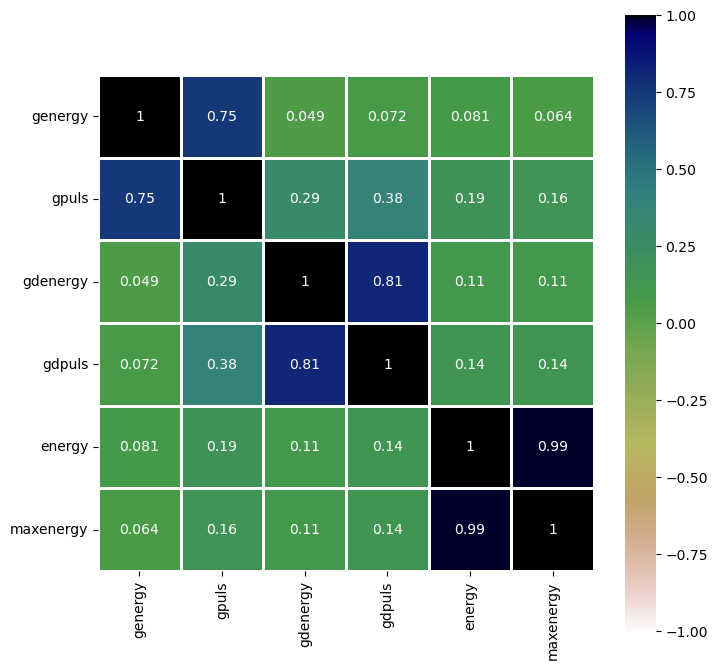

In [21]:

### Numeric Feature Scaling


df[col_list_numerical].describe()

df_corr = df[col_list_numerical].corr()

df_corr

plt.figure(figsize=[8, 8])
sns.heatmap(data=df_corr, vmin=-1, vmax=1, cmap='gist_earth_r', annot=True, square=True, linewidths=1)
plt.xticks(rotation=90)
plt.yticks(rotation=0)


C:\Users\katen\AppData\Local\Temp\ipykernel_21868\935168119.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['genergy'], hist=True)


<Axes: xlabel='genergy', ylabel='Density'>

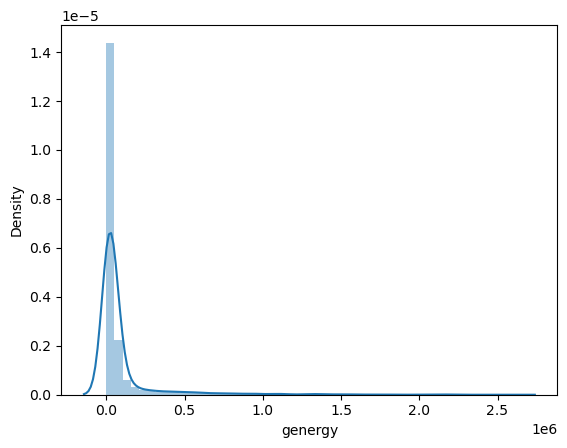

In [20]:
sns.distplot(df['genergy'], hist=True)


C:\Users\katen\AppData\Local\Temp\ipykernel_21868\29566145.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.log(df['genergy']), hist=True)


<Axes: xlabel='genergy', ylabel='Density'>

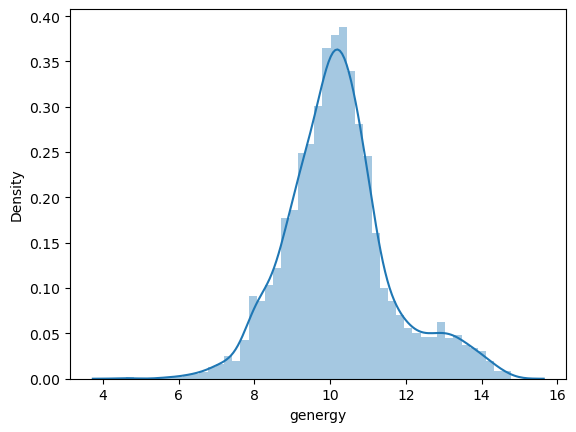

In [21]:
sns.distplot(np.log(df['genergy']), hist=True)


C:\Users\katen\AppData\Local\Temp\ipykernel_21868\3948116624.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['gpuls'], hist=True)


<Axes: xlabel='gpuls', ylabel='Density'>

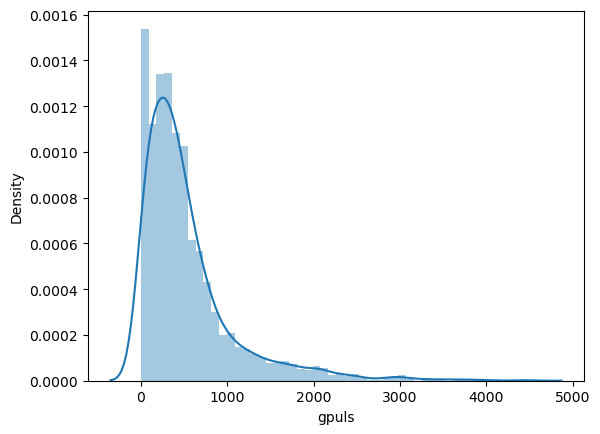

In [22]:
sns.distplot(df['gpuls'], hist=True)


C:\Users\katen\AppData\Local\Temp\ipykernel_21868\654751003.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.log(df['gpuls']), hist=True)


<Axes: xlabel='gpuls', ylabel='Density'>

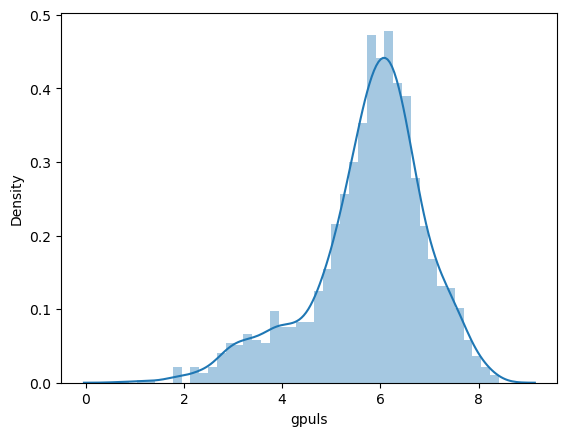

In [23]:
sns.distplot(np.log(df['gpuls']), hist=True)


<Axes: xlabel='genergy', ylabel='gpuls'>

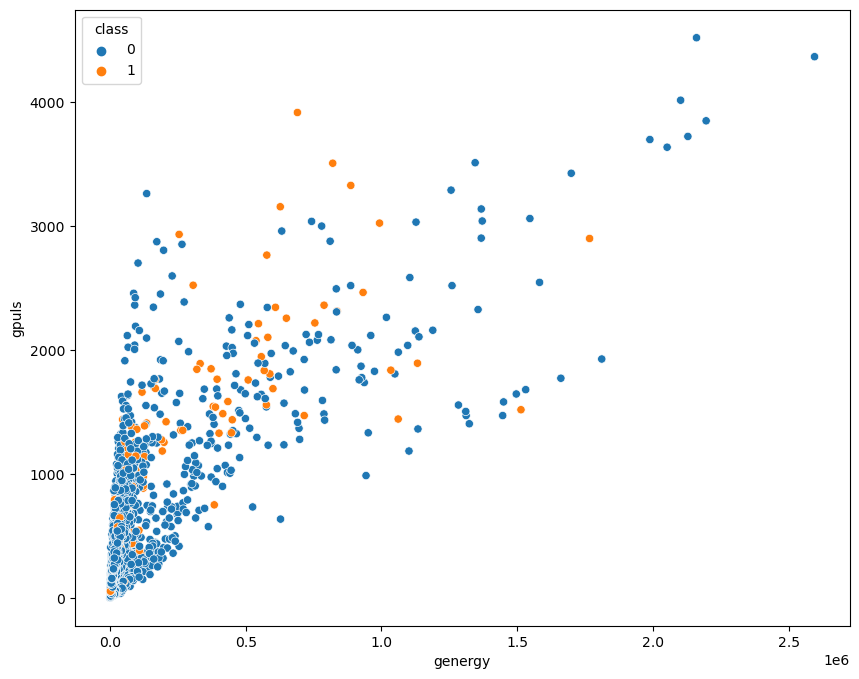

In [24]:

plt.figure(figsize=[10, 8])
sns.scatterplot(x='genergy', y='gpuls', hue='class', data=df)

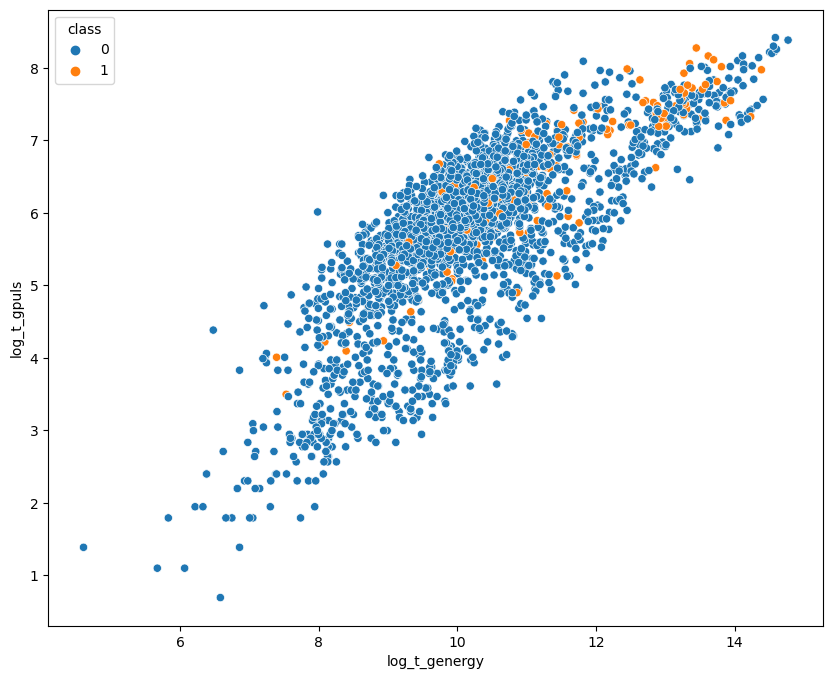

In [22]:

# Applying log transform

df['log_t_genergy'] = np.log(df['genergy'])
df['log_t_gpuls'] = np.log(df['gpuls'])

plt.figure(figsize=[10, 8])
sns.scatterplot(x='log_t_genergy', y='log_t_gpuls', hue='class', data=df)

df.drop(columns=['log_t_genergy', 'log_t_gpuls'], inplace=True)

<Axes: xlabel='gdenergy', ylabel='gdpuls'>

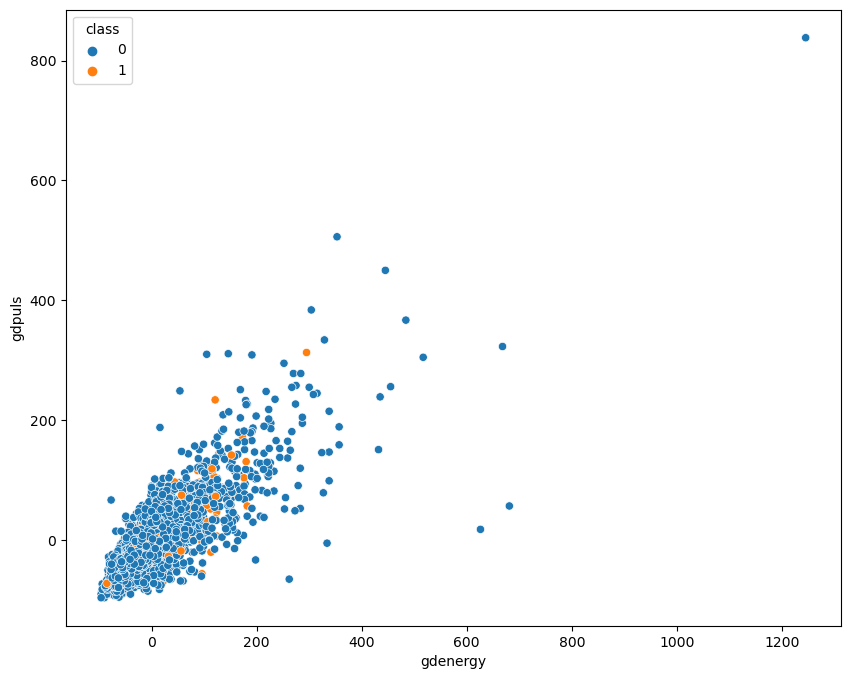

In [26]:

"""#### gdenergy and gdpuls"""
"""There are negative shifts in gdenergy and gdpuls because of which log transformation is not going to be the best choice. So, trying out square root transformation."""

plt.figure(figsize=[10, 8])
sns.scatterplot(x='gdenergy', y='gdpuls', hue='class', data=df)


In [23]:

def shifted_log_func(df_col):
    return np.log(1 + df_col)

dict_num_cols_trnsfm = {'genergy': np.log,
                        'gpuls' : np.log,
                        'gdenergy': stats.zscore,
                        'gdenergy': stats.zscore, 
                        'energy': shifted_log_func}

for col_names, transfm_func in dict_num_cols_trnsfm.items():
    df['scaled_' + col_names] = transfm_func(df[col_names])
df.drop(columns=col_list_numerical, inplace=True)
df.head()

df[[col for col in df.columns if 'scaled_' in col]].describe()


,scaled_genergy,scaled_gpuls,scaled_gdenergy,scaled_energy
count,2584.000000,2584.000000,2.584000e+03,2584.000000
mean,10.221063,5.761759,-2.199823e-17,3.481643
std,1.393919,1.173926,1.000194e+00,4.117081
min,4.605170,0.693147,-1.349577e+00,0.000000
25%,9.363919,5.247024,-6.148645e-01,0.000000
50%,10.145845,5.937536,-2.288290e-01,0.000000
75%,10.874880,6.505784,3.190922e-01,7.863651
max,14.769348,8.415825,1.534957e+01,12.904210


In [24]:
df.drop(columns=['nbumps6', 'nbumps7', 'nbumps89'], inplace=True)


In [25]:

col_list_discrete = list(set(col_list_discrete) - set(['nbumps6', 'nbumps7', 'nbumps89']))
col_list_discrete

['nbumps', 'nbumps3', 'nbumps4', 'nbumps2', 'nbumps5']

In [30]:

for each_col in col_list_discrete:
    data_crosstab = pd.crosstab(df[each_col], df[label], colnames=['class'])
    print(data_crosstab)
    print('-----')


class       0   1
nbumps2          
0.0      1832  69
1.0       399  56
2.0       122  29
3.0        47  11
4.0         8   4
5.0         5   1
8.0         1   0
-----
class       0   1
nbumps3          
0.0      1806  73
1.0       442  55
2.0       115  25
3.0        35   7
4.0        12   8
5.0         3   2
7.0         1   0
-----
class      0   1
nbumps          
0.0     1424  40
1.0      567  31
2.0      208  37
3.0       96  31
4.0       59  10
5.0       30   8
6.0       19   9
7.0        3   2
8.0        6   1
9.0        2   1
-----
class       0    1
nbumps4           
0.0      2278  148
1.0       123   20
2.0        12    1
3.0         1    1
-----
class       0    1
nbumps5           
0.0      2403  169
1.0        11    1
-----


(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5]),
 [Text(0, 0.5, 'nbumps'),
  Text(0, 1.5, 'nbumps2'),
  Text(0, 2.5, 'nbumps3'),
  Text(0, 3.5, 'nbumps4'),
  Text(0, 4.5, 'nbumps5'),
  Text(0, 5.5, 'class'),
  Text(0, 6.5, 'seismic_enc_0'),
  Text(0, 7.5, 'seismoacoustic_enc_0'),
  Text(0, 8.5, 'shift_enc_0'),
  Text(0, 9.5, 'ghazard_enc_0'),
  Text(0, 10.5, 'scaled_genergy'),
  Text(0, 11.5, 'scaled_gpuls'),
  Text(0, 12.5, 'scaled_gdenergy'),
  Text(0, 13.5, 'scaled_energy')])

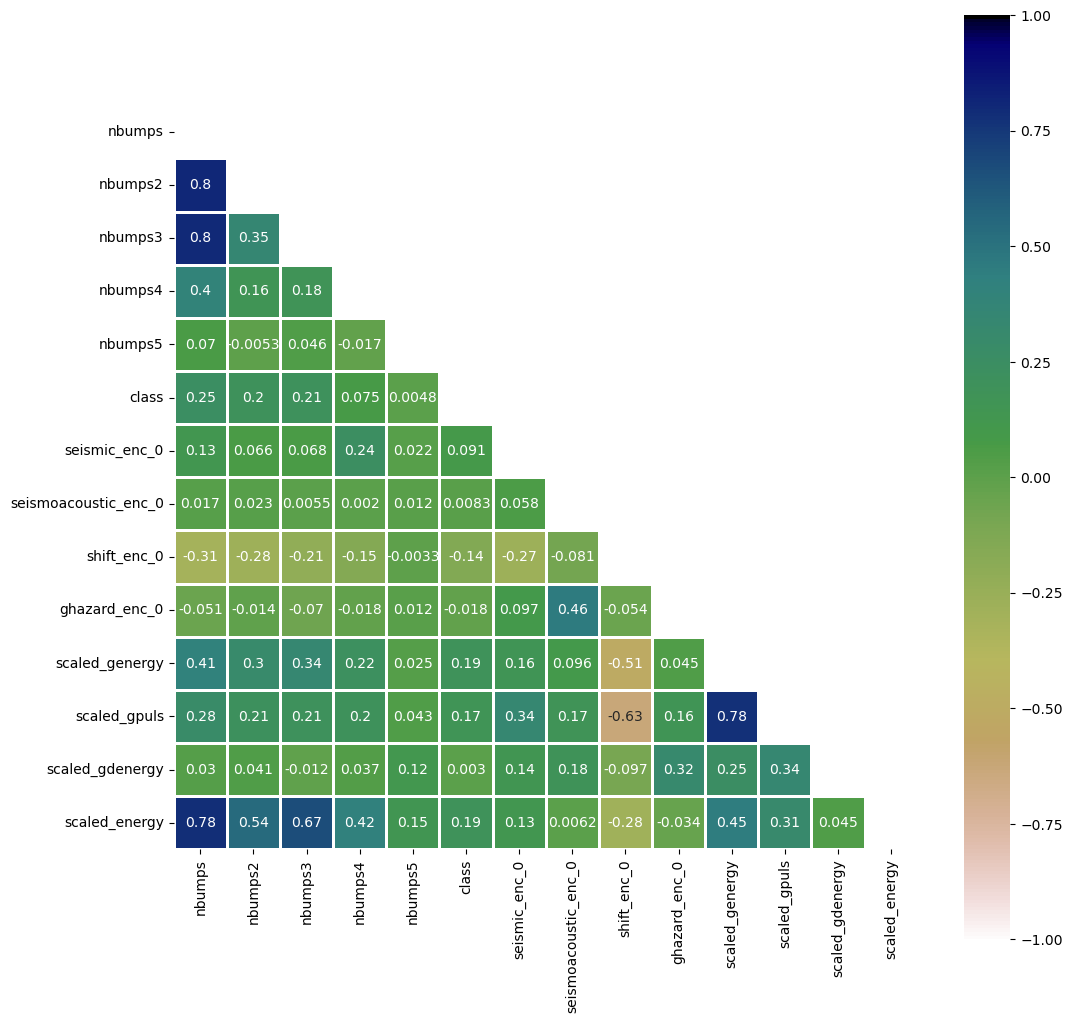

In [26]:
df_corr = df.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(df_corr, dtype=bool))

plt.figure(figsize=[12, 12])
sns.heatmap(data=df_corr, mask=mask, vmin=-1, vmax=1, cmap='gist_earth_r', annot=True, square=True, linewidths=1)
plt.xticks(rotation=90)
plt.yticks(rotation=0)

In [27]:

X_cols = list(set(df.columns) - set([label]))
X_cols

['nbumps',
 'nbumps3',
 'nbumps4',
 'nbumps2',
 'seismoacoustic_enc_0',
 'nbumps5',
 'ghazard_enc_0',
 'scaled_genergy',
 'scaled_gdenergy',
 'scaled_energy',
 'seismic_enc_0',
 'shift_enc_0',
 'scaled_gpuls']

In [28]:

X = df[list(set(df.columns) - set([label]))].values
y = df[label]
X.shape, y.shape

type(X), type(y)

stratified_split = StratifiedShuffleSplit(n_splits=1, test_size=0.20)

In [29]:

for train_idx, test_idx in stratified_split.split(X, y):
    print(len(train_idx))
    print(len(test_idx))
    y_train= y[train_idx]
    X_train = X[train_idx]
    X_test, y_test = X[test_idx], y[test_idx]

len(X_train), len(y_train), len(X_test), len(y_test)

print("Training Set Target Class Distribution:")
print(y_train.value_counts()/len(y_train))
print("Test Set Target Class Distribution:")
print(y_test.value_counts()/len(y_test))


2067
517
Training Set Target Class Distribution:
0    0.934204
1    0.065796
Name: class, dtype: float64
Test Set Target Class Distribution:
0    0.934236
1    0.065764
Name: class, dtype: float64


In [30]:

X_train = pd.DataFrame(X_train, columns=X_cols)
X_test = pd.DataFrame(X_test, columns=X_cols)

# MLE logistic regression

In [77]:
#function to find Hessian
def fprime(beta,x,y):
    return  x.T.dot(sigma(x,beta)-y)
def Hessian(beta,x):  
    S = np.diag(sigma(x,beta)*(1-sigma(x,beta)))
    hes = x.T.dot(S.dot(x))
    return hes
def NewtonRaphsonLogistReg(beta0,x,y,maxiter,tolerance):
    i = 0
    beta = beta0
    NegLogLike = nll(beta,x,y)
    AbDiff = 1; #anything bigger than tolerance would do here
    while (AbDiff> tolerance) & (i<maxiter):
        i =i+1;
        print('iteration ',i,' Negative Log likelihood ',NegLogLike, ' AbDiff ', AbDiff)
        grad = fprime(beta,x,y)
        H = Hessian(beta,x)
        H_inv = sc.linalg.inv(H) 
        beta = beta - H_inv.dot(grad)
        NegLogLike_new = nll(beta,x,y)
        AbDiff = np.abs(NegLogLike_new-NegLogLike)
        NegLogLike = NegLogLike_new
    if (iter == maxiter):
        print('Did not Converge') 
    return beta, H_inv
def nll(beta, x, y):
    t = y.T.dot(np.log(sigma(x,beta)))+ (1-y).T.dot(np.log(1.-sigma(x,beta)))
    return -t

In [78]:
Xt = X_train[predictors]
n,p = Xt.shape
beta0 = np.zeros(p)
tolerance = 1e-05
maxiter = 100 
beta_mle, cov = NewtonRaphsonLogistReg(beta0,Xt, y_train.values,maxiter,tolerance)
print(beta_mle)

iteration  1  Negative Log likelihood  1432.7352222174084  AbDiff  1
iteration  2  Negative Log likelihood  569.2296714697262  AbDiff  863.5055507476822
iteration  3  Negative Log likelihood  485.5411009389648  AbDiff  83.68857053076141
iteration  4  Negative Log likelihood  472.6455608269504  AbDiff  12.89554011201443
iteration  5  Negative Log likelihood  471.3255599581386  AbDiff  1.3200008688117464
iteration  6  Negative Log likelihood  471.2884426204507  AbDiff  0.03711733768790282
iteration  7  Negative Log likelihood  471.2883974599692  AbDiff  4.516048153391239e-05
[ 0.15875249 -0.0247114   0.03253126  0.07779861  0.00575316  0.34976403
 -1.76915939 -0.22179095 -0.2908172  -0.04591731 -0.26272908]


In [79]:
#Invert for the covariance and find 95% CIs
#cov = sc.linalg.inv(H)
se = np.sqrt(np.diag(cov))
lower95 = beta_mle - 1.96*se
upper95 = beta_mle + 1.96*se

#present the output via a pandas data frame
results = np.column_stack([beta_mle,se,lower95,upper95])
col = ['coefficient','se','lower 95% bound','upper 95% bound']
ind = predictors
results = pd.DataFrame(results,columns = col,index=ind)
results

,coefficient,se,lower 95% bound,upper 95% bound
seismic_enc_0,0.158752,0.192905,-0.219342,0.536847
seismoacoustic_enc_0,-0.024711,0.190379,-0.397853,0.348431
scaled_gdenergy,0.032531,0.103341,-0.170016,0.235079
nbumps3,0.077799,0.144269,-0.204970,0.360567
scaled_gpuls,0.005753,0.178350,-0.343812,0.355318
nbumps,0.349764,0.089351,0.174637,0.524891
shift_enc_0,-1.769159,0.321872,-2.400028,-1.138291
nbumps4,-0.221791,0.291272,-0.792685,0.349103
ghazard_enc_0,-0.290817,0.345473,-0.967945,0.386310
nbumps5,-0.045917,1.088240,-2.178867,2.087032


0.9323017408123792 111.53072099857161
0.9323017408123792 111.53072099857158
0.7796248934356351


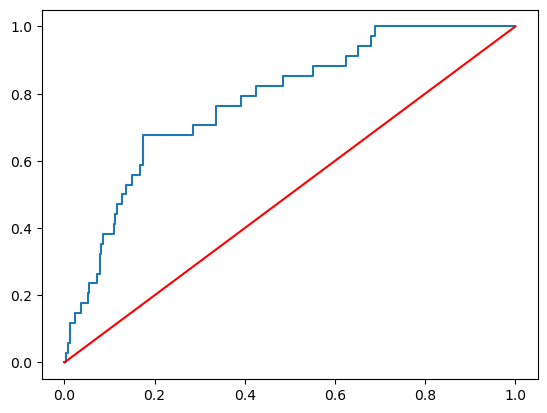

In [84]:
#prediction assessment for MLE approach
predict_probs = sigma(X_test[predictors],beta_mle)
predict_class = (predict_probs > .5)

AccRate_MLE = np.sum(predict_class==y_test.values)/len(y_test) 
LS_MLE = -(y_test.values.T.dot(np.log(predict_probs))+(1-y_test.values).T.dot(np.log(1-predict_probs)))

print(AccRate_MLE, LS_MLE)
print(accuracy_score(y_test,predict_class), log_loss(y_test, predict_probs, normalize=False))

fpr,tpr,thresholds = roc_curve(y_test,predict_probs)
xgrid = np.linspace(0,1,100) 
plt.plot(fpr,tpr)
plt.plot(xgrid,xgrid,'red')
AUC_MLE = roc_auc_score(y_test,predict_probs)
print(AUC_MLE)

# bayesian logistic regression

In [39]:
def nll(beta, x, y):
    t = y.T.dot(np.log(sigma(x,beta)))+ (1-y).T.dot(np.log(1.-sigma(x,beta)))
    return -t
def sigma(x,beta):
    xbeta = x.dot(beta)
    d = 1. + np.exp(-xbeta)
    return d**(-1)

In [40]:
def neg_post(beta, x, y, m0, S0):
    logprior =  - .5* (beta-m0).T @ S0 @ (beta-m0)
    return  nll(beta, x, y) -  logprior
def neg_post_prime(beta, x, y, m0, S0):
    return  x.T.dot(sigma(x,beta)-y)+S0.dot(beta-m0)
def laplace_prec(beta, x, S0):
    n = x.shape[0]  
    S = np.diag(sigma(x,beta)*(1-sigma(x,beta)))
    prec = S0.values + x.T.dot(S.dot(x))    
    return prec
def NewtonRaphsonBayesLogReg(beta0,x,y,m0,S0,maxiter,tolerance):
    i = 0
    beta = beta0
    NegLogPost = neg_post(beta, x, y, m0, S0)
    AbDiff = 1; #anything bigger than tolerance would do here
    while (AbDiff> tolerance) & (i<maxiter):
        i =i+1;
        print('iteration ',i,' Negative Log Posterior ',NegLogPost, ' AbDiff ', AbDiff)
        grad = neg_post_prime(beta, x, y, m0, S0)
        H = laplace_prec(beta, x, S0)
        H_inv = sc.linalg.inv(H) 
        beta = beta - H_inv.dot(grad)
        NegLogPost_new = neg_post(beta, x, y, m0, S0)
        AbDiff = np.abs(NegLogPost_new-NegLogPost)
        NegLogPost = NegLogPost_new
    if (iter == maxiter):
        print('Did not Converge') 
    return beta, H_inv

In [38]:
X_cols

['nbumps2',
 'seismic_enc_0',
 'seismoacoustic_enc_0',
 'scaled_gdenergy',
 'nbumps3',
 'scaled_energy',
 'scaled_gpuls',
 'nbumps',
 'shift_enc_0',
 'nbumps4',
 'ghazard_enc_0',
 'nbumps5',
 'scaled_genergy']

In [51]:
y_train.shape
#X_train.shape

(2067,)

In [53]:
predictors = [
 'seismic_enc_0',
 'seismoacoustic_enc_0',
 'scaled_gdenergy',
 'nbumps3',
 'scaled_gpuls',
 'nbumps',
 'shift_enc_0',
 'nbumps4',
 'ghazard_enc_0',
 'nbumps5',
 'scaled_genergy']

Xt = X_train[predictors]
#print(Xt.shape)
n,p = Xt.shape
#print(p)
m0 = np.zeros(p)
#print(m0)
S0 = Xt.T.dot(Xt)/n
#print(S0)
beta0 = np.zeros(p)
#print(beta0)
tolerance = 1e-05
maxiter = 100 
beta_map, cov = NewtonRaphsonBayesLogReg(beta0,Xt, y_train.values,
                                                  m0,S0,maxiter,tolerance)
print(beta_map)

iteration  1  Negative Log Posterior  1432.7352222174084  AbDiff  1
iteration  2  Negative Log Posterior  571.341573151481  AbDiff  861.3936490659273
iteration  3  Negative Log Posterior  489.19626555144566  AbDiff  82.14530760003538
iteration  4  Negative Log Posterior  477.1344623424262  AbDiff  12.061803209019445
iteration  5  Negative Log Posterior  476.0547718163299  AbDiff  1.0796905260963285
iteration  6  Negative Log Posterior  476.03244916413854  AbDiff  0.02232265219134888
iteration  7  Negative Log Posterior  476.0324351983981  AbDiff  1.3965740436105989e-05
[ 0.15473133 -0.02404546  0.03369686  0.07775966  0.00528286  0.34555741
 -1.68015458 -0.2178618  -0.28251037 -0.05124658 -0.26042856]


In [54]:
#95% credible intervals
se = np.sqrt(np.diag(cov))
lower95 = beta_map - 1.96*se
upper95 = beta_map + 1.96*se

#present the output via a pandas data frame
results = np.column_stack([beta_map,se,lower95,upper95])
col = ['post mean','post se','lower 95% bound','upper 95% bound']
ind = predictors
results = pd.DataFrame(results,columns = col,index=ind)
results

,post mean,post se,lower 95% bound,upper 95% bound
seismic_enc_0,0.154731,0.190582,-0.218810,0.528273
seismoacoustic_enc_0,-0.024045,0.187804,-0.392141,0.344050
scaled_gdenergy,0.033697,0.101415,-0.165077,0.232470
nbumps3,0.077760,0.143483,-0.203466,0.358985
scaled_gpuls,0.005283,0.173912,-0.335584,0.346150
nbumps,0.345557,0.088816,0.171478,0.519636
shift_enc_0,-1.680155,0.305490,-2.278915,-1.081395
nbumps4,-0.217862,0.289117,-0.784531,0.348808
ghazard_enc_0,-0.282510,0.338978,-0.946907,0.381886
nbumps5,-0.051247,1.077294,-2.162742,2.060249


In [75]:
#Calculate model evidence and BIC
def neg_post(beta, x, y, m0, S0):
    logprior =  - .5* (beta-m0).T @ S0 @ (beta-m0)
    return  nll(beta, x, y) -  logprior
n,p = X_train.shape
logEv = -neg_post(beta_map, X_train[predictors], y_train.values, m0, S0) + (p/2)*np.log(2*np.pi) + (1/2)*np.log(sc.linalg.det(cov))
BIC = -nll(beta_map, X_train[predictors], y_train.values) -(p/2)*np.log(n)
logEv, BIC

(-484.97911230200134, -520.9968925372193)

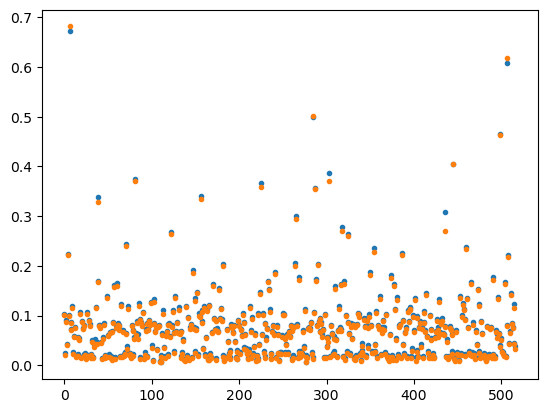

In [85]:
#Calculate the prediction probabilities with Bayesian Logistic regression

N = 10000 #number of Monte Carlo samples
# draw N samples from the approximate posterior (Laplace) of beta
betas = np.random.multivariate_normal(beta_map,cov,N)
Xbetas = X_test[predictors].dot(betas.T)
#apply sigmoid
d = 1/(1. + np.exp(-Xbetas))
pred_probs_blr = np.mean(d, axis=1)
plt.plot(pred_probs_blr,'.')
plt.plot(predict_probs,'.') #- MLE 

In [70]:
y_test.T.shape

(517,)

0.9323017408123792 111.6532279708692 0.7802338326635001
0.9323017408123792 111.53072099857161 0.7796248934356351


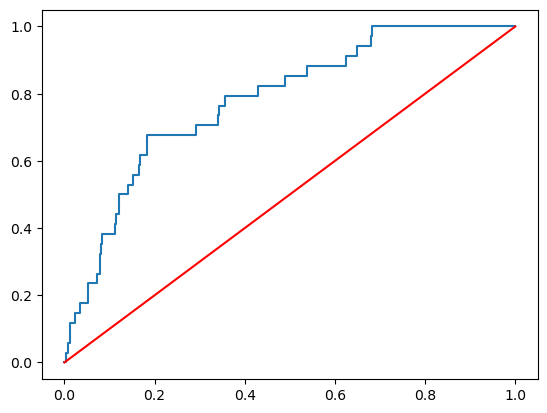

In [87]:
pred_class_blr = (pred_probs_blr > .5)
AccRate = np.sum(pred_class_blr==y_test.values)/len(y_test) 
LS = -(y_test.values.T.dot(np.log(pred_probs_blr))+(1-y_test.values).T.dot(np.log(1-pred_probs_blr)))

fpr,tpr,thresholds = roc_curve(y_test,pred_probs_blr)
xgrid = np.linspace(0,1,100) 
plt.plot(fpr,tpr)
plt.plot(xgrid,xgrid,'red')
AUC = roc_auc_score(y_test,pred_probs_blr)
print(AccRate, LS, AUC)
print(AccRate_MLE, LS_MLE, AUC_MLE)

# SMOTE

Counter({0: 1931, 1: 136})


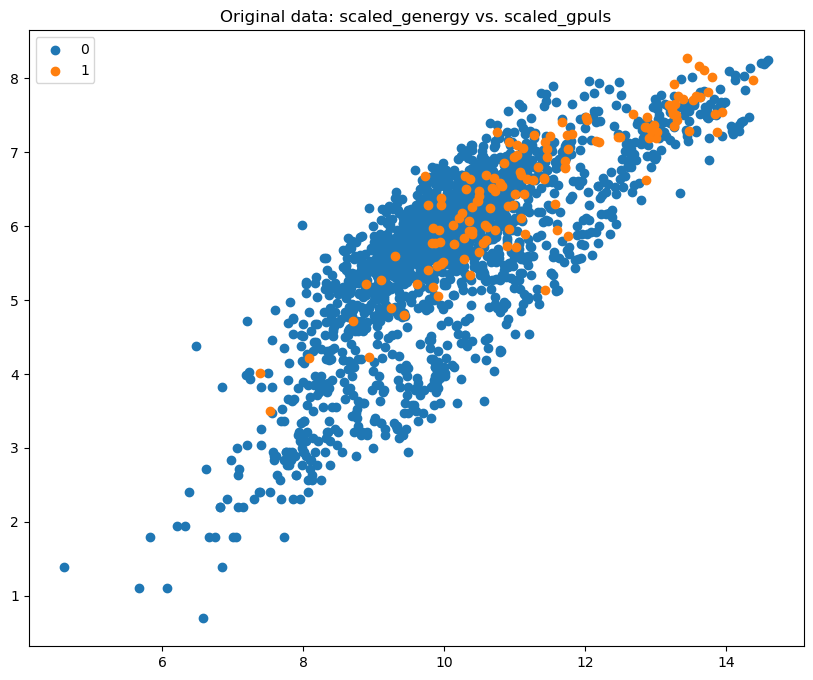

C:\Users\katen\AppData\Local\Temp\ipykernel_2500\1412407971.py:22: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(X_train['nbumps'])


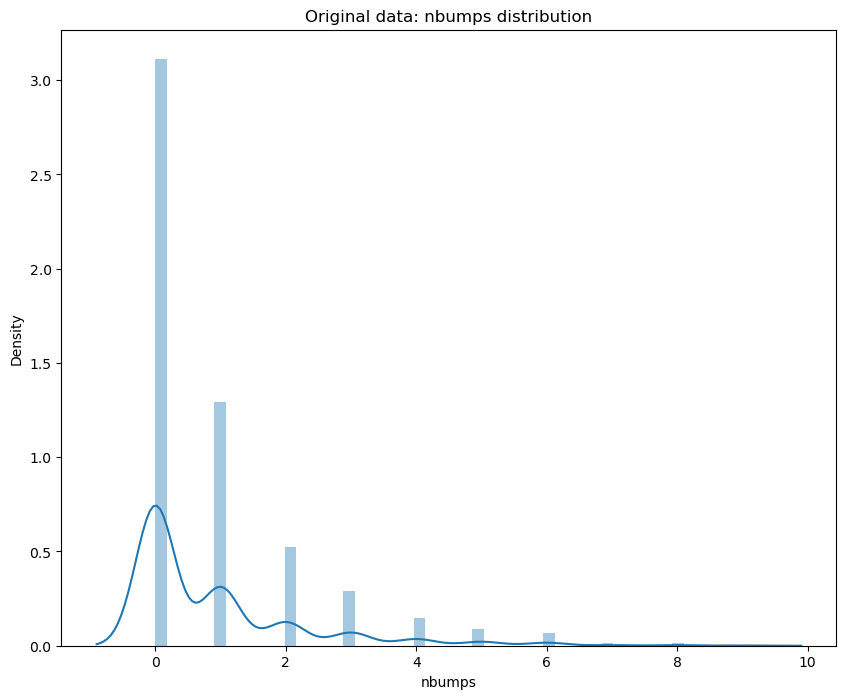

In [31]:

counter = Counter(y_train)
print(counter)

#sns.scatterplot(x='scaled_genergy', y='scaled_gpuls', hue=class, data=X_train)

# View current data
plt.figure(figsize=[10, 8])


for lb, _ in counter.items():
	row_ix = np.where(y_train == lb)[0]
	plt.scatter(X_train.loc[row_ix, ['scaled_genergy']], 
	            X_train.loc[row_ix, ['scaled_gpuls']], label=str(lb))

	#plt.scatter(X[y == label].scaled_genergy, X[y == label].scaled_gpuls, label=str(label))
plt.title("Original data: scaled_genergy vs. scaled_gpuls")
plt.legend()
plt.show()

plt.figure(figsize=[10, 8])

sns.distplot(X_train['nbumps'])
plt.title("Original data: nbumps distribution")

plt.show()

In [32]:
print('Original dataset shape %s' % Counter(y))


Original dataset shape Counter({0: 2414, 1: 170})


In [90]:
! pip install imblearn

In [95]:
X_cols

['nbumps2',
 'seismic_enc_0',
 'seismoacoustic_enc_0',
 'scaled_gdenergy',
 'nbumps3',
 'scaled_energy',
 'scaled_gpuls',
 'nbumps',
 'shift_enc_0',
 'nbumps4',
 'ghazard_enc_0',
 'nbumps5',
 'scaled_genergy']

In [33]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
fs = SelectKBest(score_func=f_classif, k='all')
fs.fit(X, y)

rate = pd.DataFrame(fs.scores_, X_cols, columns=['score'])
rate = rate.sort_values('score', axis=0)
rate

,score
scaled_gdenergy,0.022577
nbumps5,0.060329
seismoacoustic_enc_0,0.175784
ghazard_enc_0,0.813177
nbumps4,14.785868
seismic_enc_0,21.356902
shift_enc_0,53.195573
scaled_gpuls,73.539207
scaled_genergy,100.355906
scaled_energy,101.651471


In [105]:
!pip install -U imbalanced-learn
!pip install -U scikit-learn


     --------------------------------------- 10.6/10.6 MB 15.6 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.4.1.post1
    Uninstalling scikit-learn-1.4.1.post1:
      Successfully uninstalled scikit-learn-1.4.1.post1


ERROR: Could not install packages due to an OSError: [WinError 5] Отказано в доступе: 'C:\\Users\\katen\\anaconda3\\Lib\\site-packages\\~-learn\\.libs\\msvcp140.dll'
Consider using the `--user` option or check the permissions.



In [108]:
pip install imbalanced-learn


Note: you may need to restart the kernel to use updated packages.


In [34]:
from imblearn.over_sampling import SMOTE

smote = SMOTE()


Resampled dataset shape Counter({0: 1931, 1: 1931})


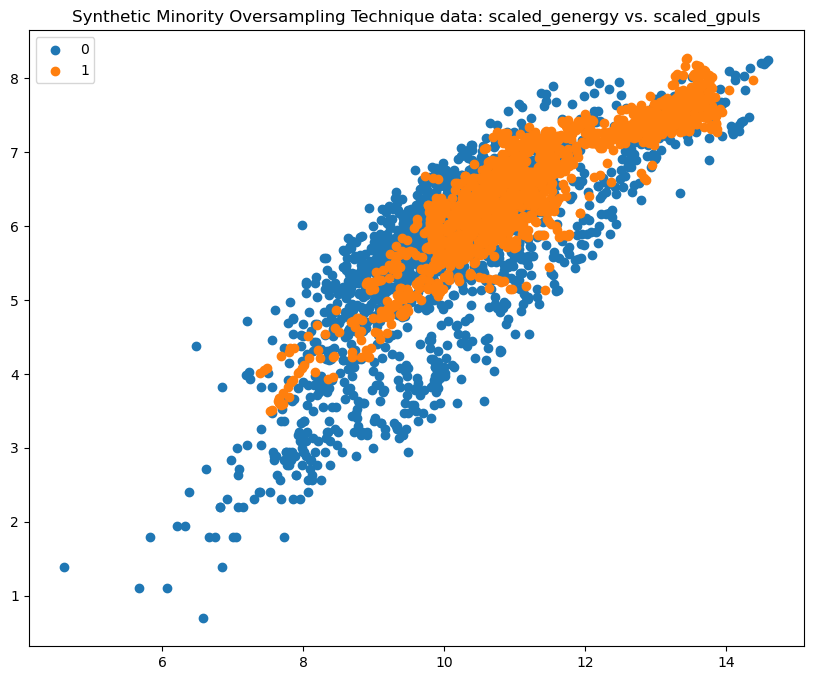

In [35]:

sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_train, y_train)

print('Resampled dataset shape %s' % Counter(y_res))

X_res = pd.DataFrame(X_res, columns=X_cols)

plt.figure(figsize=[10, 8])
plt.title("Synthetic Minority Oversampling Technique data: scaled_genergy vs. scaled_gpuls")

for lb, _ in counter.items():
	row_ix = np.where(y_res == lb)[0]
	plt.scatter(X_res.loc[y_res == lb, ['scaled_genergy']], 
	            X_res.loc[y_res == lb, ['scaled_gpuls']], label=str(lb))



plt.legend()
plt.show()

C:\Users\katen\AppData\Local\Temp\ipykernel_2500\310486510.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(X_res['nbumps'])


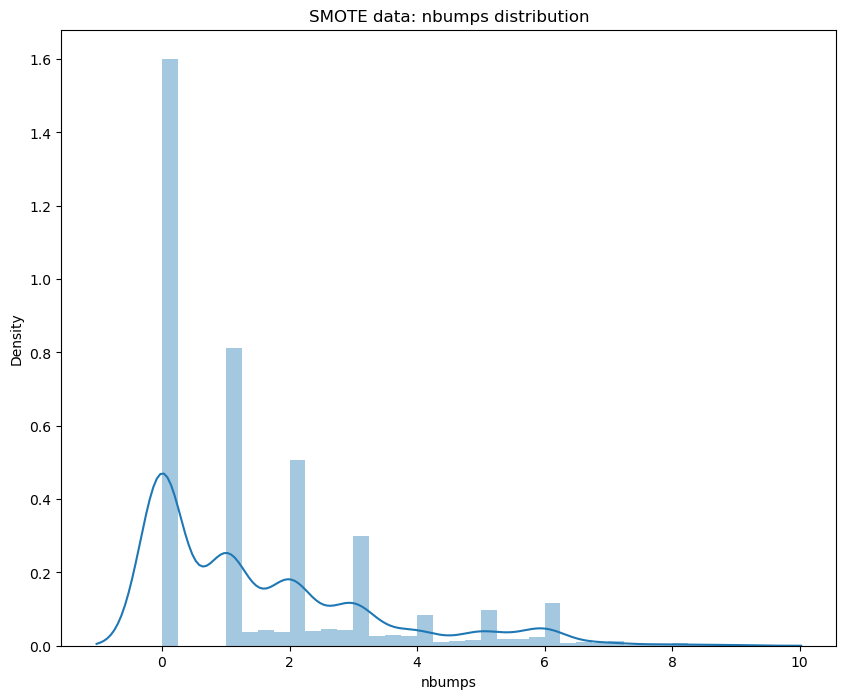

In [36]:
"""*Some non-natural number of Bumps! (float values!)*"""

plt.figure(figsize=[10, 8])

sns.distplot(X_res['nbumps'])
plt.title("SMOTE data: nbumps distribution")

plt.show()

In [41]:
predictors = [
 'seismic_enc_0',
 'seismoacoustic_enc_0',
 'scaled_gdenergy',
 'nbumps3',
 'scaled_gpuls',
 'nbumps',
 'shift_enc_0',
 'nbumps4',
 'ghazard_enc_0',
 'nbumps5',
 'scaled_genergy']

Xt_new = X_res[predictors]
#print(Xt.shape)
n_new,p_new = Xt_new.shape
#print(p)
m0_new = np.zeros(p_new)
#print(m0)
S0_new = Xt_new.T.dot(Xt_new)/n_new
#print(S0)
beta0_new = np.zeros(p_new)
#print(beta0)
tolerance = 1e-05
maxiter = 100 
beta_map_new, cov_new = NewtonRaphsonBayesLogReg(beta0_new,Xt_new, y_res.values,
                                                  m0_new,S0_new,maxiter,tolerance)
print(beta_map_new)

iteration  1  Negative Log Posterior  2676.9344113225116  AbDiff  1
iteration  2  Negative Log Posterior  2189.1854164357765  AbDiff  487.7489948867351
iteration  3  Negative Log Posterior  2166.891773532318  AbDiff  22.293642903458476
iteration  4  Negative Log Posterior  2166.4322587052457  AbDiff  0.4595148270723257
iteration  5  Negative Log Posterior  2166.4319364026983  AbDiff  0.0003223025473744201
[ 0.32094655 -0.12896441 -0.11277717 -0.04093128  0.42713039  0.55955886
 -1.25211547 -0.67697132 -0.5781904  -0.99194147 -0.28619129]


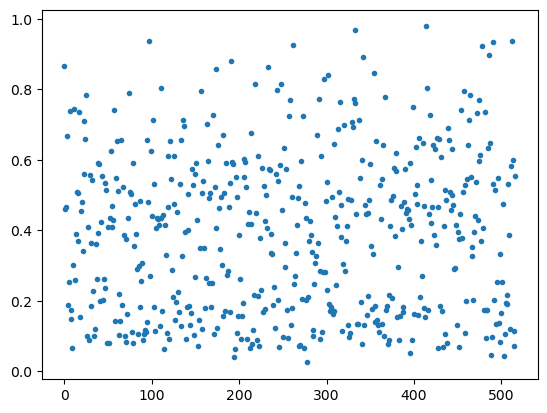

In [43]:
#Calculate the prediction probabilities with Bayesian Logistic regression

N = 10000 #number of Monte Carlo samples
# draw N samples from the approximate posterior (Laplace) of beta
betas_new = np.random.multivariate_normal(beta_map_new,cov_new,N)
Xbetas_new = X_test[predictors].dot(betas_new.T)
#apply sigmoid
d_new = 1/(1. + np.exp(-Xbetas_new))
pred_probs_blr_new = np.mean(d_new, axis=1)
plt.plot(pred_probs_blr_new,'.')


0.688588007736944 298.3926821849782 0.737608086712946


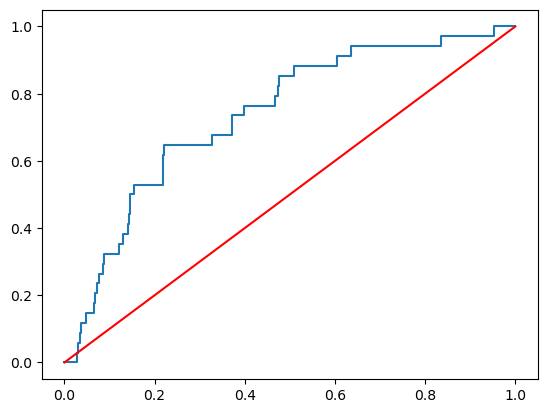

In [46]:
pred_class_blr_new = (pred_probs_blr_new > .5)
AccRate_new = np.sum(pred_class_blr_new==y_test.values)/len(y_test) 
LS_new = -(y_test.values.T.dot(np.log(pred_probs_blr_new))+(1-y_test.values).T.dot(np.log(1-pred_probs_blr_new)))

fpr,tpr,thresholds = roc_curve(y_test,pred_probs_blr_new)
xgrid = np.linspace(0,1,100) 
plt.plot(fpr,tpr)
plt.plot(xgrid,xgrid,'red')
AUC_new = roc_auc_score(y_test,pred_probs_blr_new)
print(AccRate_new, LS_new, AUC_new)


# MLE SMOTE

In [47]:
#function to find Hessian
def fprime(beta,x,y):
    return  x.T.dot(sigma(x,beta)-y)
def Hessian(beta,x):  
    S = np.diag(sigma(x,beta)*(1-sigma(x,beta)))
    hes = x.T.dot(S.dot(x))
    return hes
def NewtonRaphsonLogistReg(beta0,x,y,maxiter,tolerance):
    i = 0
    beta = beta0
    NegLogLike = nll(beta,x,y)
    AbDiff = 1; #anything bigger than tolerance would do here
    while (AbDiff> tolerance) & (i<maxiter):
        i =i+1;
        print('iteration ',i,' Negative Log likelihood ',NegLogLike, ' AbDiff ', AbDiff)
        grad = fprime(beta,x,y)
        H = Hessian(beta,x)
        H_inv = sc.linalg.inv(H) 
        beta = beta - H_inv.dot(grad)
        NegLogLike_new = nll(beta,x,y)
        AbDiff = np.abs(NegLogLike_new-NegLogLike)
        NegLogLike = NegLogLike_new
    if (iter == maxiter):
        print('Did not Converge') 
    return beta, H_inv
def nll(beta, x, y):
    t = y.T.dot(np.log(sigma(x,beta)))+ (1-y).T.dot(np.log(1.-sigma(x,beta)))
    return -t

In [48]:
Xt = X_res[predictors]
n,p = Xt.shape
beta0 = np.zeros(p)
tolerance = 1e-05
maxiter = 100 
beta_mle, cov = NewtonRaphsonLogistReg(beta0,Xt, y_res.values,maxiter,tolerance)
print(beta_mle)

iteration  1  Negative Log likelihood  2676.9344113225116  AbDiff  1
iteration  2  Negative Log likelihood  2188.5726335573727  AbDiff  488.36177776513887
iteration  3  Negative Log likelihood  2166.088732332333  AbDiff  22.483901225039517
iteration  4  Negative Log likelihood  2165.617906858059  AbDiff  0.47082547427407917
iteration  5  Negative Log likelihood  2165.6175652888933  AbDiff  0.0003415691658119613
[ 0.32133178 -0.12905026 -0.11297622 -0.0407941   0.42859741  0.5609635
 -1.254359   -0.6786542  -0.57962807 -0.99399805 -0.28715381]


In [49]:
#Invert for the covariance and find 95% CIs
#cov = sc.linalg.inv(H)
se = np.sqrt(np.diag(cov))
lower95 = beta_mle - 1.96*se
upper95 = beta_mle + 1.96*se

#present the output via a pandas data frame
results = np.column_stack([beta_mle,se,lower95,upper95])
col = ['coefficient','se','lower 95% bound','upper 95% bound']
ind = predictors
results = pd.DataFrame(results,columns = col,index=ind)
results

,coefficient,se,lower 95% bound,upper 95% bound
seismic_enc_0,0.321332,0.088023,0.148807,0.493856
seismoacoustic_enc_0,-0.129050,0.084271,-0.294221,0.036120
scaled_gdenergy,-0.112976,0.047424,-0.205927,-0.020025
nbumps3,-0.040794,0.077131,-0.191970,0.110382
scaled_gpuls,0.428597,0.083930,0.264094,0.593100
nbumps,0.560964,0.050846,0.461305,0.660622
shift_enc_0,-1.254359,0.108497,-1.467013,-1.041705
nbumps4,-0.678654,0.140198,-0.953442,-0.403867
ghazard_enc_0,-0.579628,0.156321,-0.886018,-0.273238
nbumps5,-0.993998,0.628545,-2.225946,0.237950


0.688588007736944 298.5439053386615
0.688588007736944 298.5439053386616
0.737729874558519


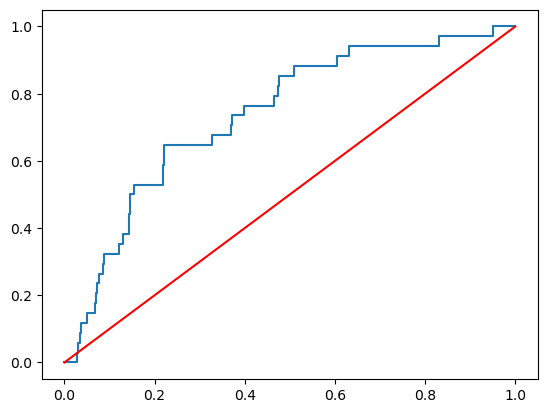

In [50]:
#prediction assessment for MLE approach
predict_probs = sigma(X_test[predictors],beta_mle)
predict_class = (predict_probs > .5)

AccRate_MLE = np.sum(predict_class==y_test.values)/len(y_test) 
LS_MLE = -(y_test.values.T.dot(np.log(predict_probs))+(1-y_test.values).T.dot(np.log(1-predict_probs)))

print(AccRate_MLE, LS_MLE)
print(accuracy_score(y_test,predict_class), log_loss(y_test, predict_probs, normalize=False))

fpr,tpr,thresholds = roc_curve(y_test,predict_probs)
xgrid = np.linspace(0,1,100) 
plt.plot(fpr,tpr)
plt.plot(xgrid,xgrid,'red')
AUC_MLE = roc_auc_score(y_test,predict_probs)
print(AUC_MLE)

# PM model